In [1]:
import time
import pickle as pickle
import yaml
import emcee

from utils import fitting as ft
from utils import graphics as gp
from utils import read_files as rd
from utils import mm_utilities as ut
from utils import analysis as an
from utils.models import *

import numpy as np
from tqdm import tqdm
import scipy

# testing
import ultranest

In [2]:
def integrate_filter(sed_nu, sed_flux, filter_nu, filter_trans):
    filter_trans_interp = np.interp(sed_nu, filter_nu, filter_trans, right=0.0, left=0.0)

    if min(filter_nu) < min(sed_nu) or max(filter_nu) > max(sed_nu):
        print("filter outside range!")
        return 0.0
    else:
        # find max filter
        i1 = np.where(filter_trans_interp >= max(filter_trans_interp)/5.)[0][0]
        i2 = np.where(filter_trans_interp >= max(filter_trans_interp)/5.)[0][-1]

        ic = np.floor((i1 + i2) / 2.)
        scale_w = np.abs(sed_flux[int(ic)])

        k1 = 0
        if np.isfinite(scale_w) and scale_w > 0:
            k1 = scale_w * np.trapz((sed_flux * sed_nu / scale_w) * filter_trans_interp, x=sed_nu)
        k2 = np.trapz(sed_nu * filter_trans_interp, x=sed_nu)
        return k1 / k2

def integrate_filter2(sed_nu, sed_flux, filter_nu, filter_trans):
    filter_trans_interp = np.interp(sed_nu, filter_nu, filter_trans, right=0.0, left=0.0)

    if min(filter_nu) < min(sed_nu) or max(filter_nu) > max(sed_nu):
        print("filter outside range!")
        return 0.0
    else:
        tmp=np.where(filter_trans_interp >= max(filter_trans_interp)/5.)[0]

        ic = np.floor((tmp[0] + tmp[-1]) / 2.)
        scale_w = np.abs(sed_flux[int(ic)])

        k1 = 0
        if np.isfinite(scale_w) and scale_w > 0:
            k1 = scale_w * np.trapz((sed_flux * sed_nu / scale_w) * filter_trans_interp, x=sed_nu)
        k2 = np.trapz(sed_nu * filter_trans_interp, x=sed_nu)
        return k1 / k2
    
def integrate_filter3(sed_nu, sed_flux, filter_nu, filter_trans):
    filter_trans_interp = np.interp(sed_nu, filter_nu, filter_trans, right=0.0, left=0.0)
    try: 
        tmp=np.where(filter_trans_interp >= max(filter_trans_interp)/5.)[0]
        ic = np.floor((tmp[0] + tmp[-1]) / 2.)
        scale_w = np.abs(sed_flux[np.int32(ic)])
        k1 = scale_w * np.trapz((sed_flux * sed_nu / scale_w) * filter_trans_interp, x=sed_nu)
        k2 = np.trapz(sed_nu * filter_trans_interp, x=sed_nu)
        return k1 / k2
    except:
        print('Filter outside of range or other problem, returning 0.')
        return 0.
    
    
def integrate_filter_fast(sed_nu, sed_flux, filter_nu, filter_trans, scale_w=1.0):
    filter_trans_interp = np.interp(sed_nu, filter_nu, filter_trans, right=0.0, left=0.0)
    try: 
        k1 = scale_w * np.trapz((sed_flux * sed_nu / scale_w) * filter_trans_interp, x=sed_nu)
        k2 = np.trapz(sed_nu * filter_trans_interp, x=sed_nu)
        return k1 / k2
    except:
        print('Filter outside of range or other problem, returning 0.')
        return 0.


In [3]:
def calc_chi2(obs_flux, error, model):
    return np.sum(((obs_flux-model)/error)**2)

def calc_chi2_mod(upper_lim, rms, model):                                                                                                                                                              
    return -2.*np.sum(np.log((np.pi/2.)**0.5*rms*(1.+scipy.special.erf(((rms-model)/((2**0.5)*rms))))))                                                                                                
                

In [4]:
def store_param(theta,param):
    ub = 0
    for i in range(len(param)):
        lb = ub
        ub = param[i]['dim'] + ub
        param[i]['current'] = theta[lb:ub]

def lnlike_fast(theta, fit_struct, data, filters, param, detection_mask):
#     print(theta.shape)
    theta = theta.flatten()
    ub = 0
    # make a function for this
    for i in range(len(param)):
        lb = ub
        ub = param[i]['dim'] + ub
        param[i]['current'] = theta[lb:ub]

    model_data = []
    number_of_component = []
    detections = []
    model_detections = []
    upper_limits = []
    model_upper_limits = []

    for i in range(len(data)):
        # function and/or early definition
        number_of_component.append(list(map(int, str.split(data[i]['component_number'][0], ','))))
        min_tmp = np.log10(min(data[i]['lambda0'])*0.01)
        max_tmp = np.log10(max(data[i]['lambda0'])*100.)
        xscale = 10**np.linspace(min_tmp, max_tmp, 2000)
        temp = np.zeros(2000)

        # list comprehension? 
        for j in range(len(number_of_component[i])):
            if fit_struct['redshift'][number_of_component[i][j]] >= 0:
                temp2 = globals()[param[number_of_component[i][j]]['func']]\
                    (xscale, param[number_of_component[i][j]]['current'], fit_struct['redshift'][number_of_component[i][j]])
            else:
                temp2 = globals()[param[number_of_component[i][j]]['func']]\
                    (xscale, param[number_of_component[i][j]]['current'])
            temp += temp2

        ndim2=len(filter_struct[i]['wav'])
        temp_mod_filter=np.array(list(map(integrate_filter3,[xscale,]*ndim2,[temp,]*ndim2,
                                 filter_struct[i]['wav'],filter_struct[i]['trans'])))

        model_data.append(temp_mod_filter)

        detections.append(data[i][detection_mask[i]])
        model_detections.append(model_data[i][np.array(detection_mask[i])])

        upper_limits.append(data[i][~detection_mask[i]])
        model_upper_limits.append(model_data[i][~np.array(detection_mask[i])])

    # pb here. Need to iterate on the list (see the [i]), not mappable? list comprehension
    chi2_classic = [calc_chi2(detections[i]['flux'],detections[i]['flux_error'],model_detections[i]) for i in range(len(detections))]
    chi2_modified = [calc_chi2_mod(upper_limits[i]['flux'],upper_limits[i]['flux_error'],model_upper_limits[i]) for i in range(len(detections))]
    
#    chi2_classic=list(map(calc_chi2,detections[i]['flux'],detections[i]['flux_error'],model_detections[i]))
#    chi2_modified=list(map(calc_chi2_mod,upper_limits[i]['flux'],upper_limits[i]['flux_error'],model_upper_limits[i]))

    return -(sum(chi2_classic)+sum(chi2_modified))

def lnlike(theta, fit_struct, data, filters, param, detection_mask):
    theta = theta.flatten()
    ub = 0
    # make a function for this
    for i in range(len(param)):
        lb = ub
        ub = param[i]['dim'] + ub
        param[i]['current'] = theta[lb:ub]

    model_data = []
    number_of_component = []
    detections = []
    model_detections = []
    upper_limits = []
    model_upper_limits = []

    for i in range(len(data)):
        # function and/or early definition
        number_of_component.append(list(map(int, str.split(data[i]['component_number'][0], ','))))
        min_tmp = np.log10(min(data[i]['lambda0'])*0.01)
        max_tmp = np.log10(max(data[i]['lambda0'])*100.)
        xscale = 10**np.linspace(min_tmp, max_tmp, 2000)
        temp = np.zeros(2000)

        # list comprehension? 
        for j in range(len(number_of_component[i])):
            if fit_struct['redshift'][number_of_component[i][j]] >= 0:
                temp2 = globals()[param[number_of_component[i][j]]['func']]\
                    (xscale, param[number_of_component[i][j]]['current'], fit_struct['redshift'][number_of_component[i][j]])
            else:
                temp2 = globals()[param[number_of_component[i][j]]['func']]\
                    (xscale, param[number_of_component[i][j]]['current'])
            temp += temp2

        # Making the sum of models to go through filters
        temp_mod_filter = np.empty(data[i]['lambda0'].size)

        for j, elem in enumerate(filters[i]['name']):
            temp_mod_filter[j] = ut.integrate_filter(xscale, temp, filters[i]['wav'][j][:], filters[i]['trans'][j][:])

        model_data.append(temp_mod_filter)

        detections.append(data[i][detection_mask[i]])
        model_detections.append(model_data[i][np.array(detection_mask[i])])

        upper_limits.append(data[i][~detection_mask[i]])
        model_upper_limits.append(model_data[i][~np.array(detection_mask[i])])


    # calculate the total chi2 which is the main part of this function
    chi2_classic = []
    chi2_modified = []

    # mappable, numpy it
    for i in range(len(detections)):
        chi2_classic.append(calc_chi2(detections[i]['flux'],
                                      detections[i]['flux_error'],
                                      model_detections[i]))
    # mappable
    for i in range(len(upper_limits)):
        chi2_modified.append(calc_chi2_mod(upper_limits[i]['flux'],
                                           upper_limits[i]['flux_error'],
                                           model_upper_limits[i]))

    return -(sum(chi2_classic)+sum(chi2_modified))

def lnprob(theta, fit_struct, data, filters, models, detection_mask):
    lp = lnprior(theta, models)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, fit_struct, data, filters, models, detection_mask)

def lnprob_fast(theta, fit_struct, data, filters, models, detection_mask):
    lp = lnprior(theta, models)
    if not np.isfinite(lp):
        return -np.inf
#     return lp + lnlike(theta, fit_struct, data, filters, models, detection_mask)
    return lp + lnlike_fast(theta, fit_struct, data, filters, models, detection_mask)

def lnprior(theta, models):
    tmin = ut.flatten_model_keyword(models, 'min')
    tmax = ut.flatten_model_keyword(models, 'max')

    # trick to get the dimension of table right...
    theta = theta.flatten()

    list_prior = [0.0 if tmin[i] < theta[i] < tmax[i] else -np.inf for i in range(len(tmin))]
    
    return sum(list_prior)


In [5]:
def fit_source(fit_struct, data_struct, filter_struct, model_struct, Parallel=0,fit_method=''):
    detection_mask = []
    for i in range(len(data_struct)):
        detection_mask.append(data_struct[i]['det_type'] == 'd')

    # flatten the parameters structure for processing
    ndim = len(ut.flatten_model_keyword(model_struct, 'param'))
    flat_param = ut.flatten_model_keyword(model_struct, 'current')
    flat_min = ut.flatten_model_keyword(model_struct, 'min')
    flat_max = ut.flatten_model_keyword(model_struct, 'max')
    coef_param = np.array([(flat_max - flat_min) / 2.]).flatten()

    pos = [flat_param + 1e-4 * coef_param * np.random.randn(ndim) for i in range(fit_struct['nwalkers'])]
    print("initialise walker positions")
    last_index = 0

    print()
    print('HMC attempt for ' + fit_struct['source'])
    filename = fit_struct['sampler_file']
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(fit_struct['nwalkers'],ndim)

    if Parallel == 0:
        sampler = emcee.EnsembleSampler(fit_struct['nwalkers'], ndim, lnprob,
                                        args=(fit_struct, data_struct, filter_struct, model_struct, detection_mask), backend=backend)
    else:
        tmp_pool = mp.ProcessingPool(Parallel)
        sampler = emcee.EnsembleSampler(fit_struct['nwalkers'], ndim, lnprob,
                                        args=(data_struct, filter_struct, model_struct, detection_mask, fit_struct['redshift']),
                                        pool=tmp_pool, backend=backend)
            
    with tqdm(total=fit_struct['nsteps']) as pbar:
        for i, result in enumerate(sampler.sample(pos, iterations=fit_struct['nsteps'])):
            pbar.update()
        print('HMC done!')
    return sampler

def fit_source_fast(fit_struct, data_struct, filter_struct, model_struct, Parallel=0,fit_method=''):
    detection_mask = []
    for i in range(len(data_struct)):
        detection_mask.append(data_struct[i]['det_type'] == 'd')

    # flatten the parameters structure for processing
    ndim = len(ut.flatten_model_keyword(model_struct, 'param'))
    flat_param = ut.flatten_model_keyword(model_struct, 'current')
    flat_min = ut.flatten_model_keyword(model_struct, 'min')
    flat_max = ut.flatten_model_keyword(model_struct, 'max')
    coef_param = np.array([(flat_max - flat_min) / 2.]).flatten()

    pos = [flat_param + 1e-4 * coef_param * np.random.randn(ndim) for i in range(fit_struct['nwalkers'])]
    print("initialise walker positions")
    last_index = 0

    print()
    print('HMC attempt for ' + fit_struct['source'])
    filename = fit_struct['sampler_file']
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(fit_struct['nwalkers'],ndim)

    if Parallel == 0:
        sampler = emcee.EnsembleSampler(fit_struct['nwalkers'], ndim, lnprob_fast,
                                        args=(fit_struct, data_struct, filter_struct, model_struct, detection_mask), backend=backend)
    else:
        tmp_pool = mp.ProcessingPool(Parallel)
        sampler = emcee.EnsembleSampler(fit_struct['nwalkers'], ndim, lnprob_fast,
                                        args=(data_struct, filter_struct, model_struct, detection_mask, fit_struct['redshift']),
                                        pool=tmp_pool, backend=backend)
            
    with tqdm(total=fit_struct['nsteps']) as pbar:
        for i, result in enumerate(sampler.sample(pos, iterations=fit_struct['nsteps'])):
            pbar.update()
        print('HMC done!')
    return sampler


In [6]:
with open('fake_source_ex1.fit', 'rb') as input:
    fit_struct = yaml.load(input)
    
# fit_struct['nsteps']=200
# fit_struct['nwalkers']=200

ut.add_filenames(fit_struct)
data_struct = rd.read_data(fit_struct['source_file'], [fit_struct['unit_flux'], fit_struct['unit_obs']])
model_struct = rd.read_mod_file(fit_struct['model_file'])
filter_struct = rd.read_filters(data_struct)

rd.set_init_guess(model_struct)
rd.set_param_start(model_struct)


nothing to convert, already in right units


/var/folders/mz/n4w7sm8s1r3096npg5l2k6_w0000gq/T/ipykernel_19218/2221774105.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  fit_struct = yaml.load(input)


[{'func': 'sync_law',
  'dim': 2,
  'param': ['$N$', '$\\alpha$'],
  'min': array([-25.,  -2.]),
  'max': array([-15.,   0.]),
  'init': array([-20.,  -1.]),
  'current': array([-20.,  -1.])}]

In [7]:
start_time=time.time()
sampler = fit_source(fit_struct, data_struct, filter_struct, model_struct,fit_method='emcee')
end_time=time.time()
print(end_time-start_time)

initialise walker positions

HMC attempt for fake_source_ex1


100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  9.48it/s]

HMC done!
2.1957130432128906


In [8]:
start_time=time.time()
sampler = fit_source_fast(fit_struct, data_struct, filter_struct, model_struct,fit_method='emcee')
end_time=time.time()
print(end_time-start_time)

initialise walker positions

HMC attempt for fake_source_ex1


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 19.19it/s]

HMC done!
1.0605571269989014


In [9]:
an.find_stats_fit(sampler, model_struct, fit_struct, data_struct)

AICc calculation... still in developpement, to be used with caution


In [10]:
%%timeit -n 100
for i in range(len(data_struct)):
    xscale = 10**np.linspace(7, 11, 2000)
    temp = sync_law(xscale,[0.,-1.],0.0)
    
    temp_mod_filter = np.empty(data_struct[i]['lambda0'].size)
    for j, elem in enumerate(filter_struct[i]['name']):
        temp_mod_filter[j] = integrate_filter(xscale, temp, filter_struct[i]['wav'][j][:], filter_struct[i]['trans'][j][:])

#print(temp_mod_filter)

4.18 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit -n 100
for i in range(len(data_struct)):
    xscale = 10**np.linspace(7, 11, 2000)
    temp = sync_law(xscale,[0.,-1.],0.0)
    ndim=len(filter_struct[i]['wav'])
    temp_mod_filter=list(map(integrate_filter,[xscale,]*ndim,
                   [temp,]*ndim,
                   filter_struct[i]['wav'],
                   filter_struct[i]['trans']))


3.57 ms ± 240 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%%timeit -n 100
for i in range(len(data_struct)):
    xscale = 10**np.linspace(7, 11, 2000)
    temp = sync_law(xscale,[0.,-1.],0.0)
    ndim=len(filter_struct[i]['wav'])
    temp_mod_filter=[integrate_filter(xscale, temp, filter_struct[i]['wav'][j][:], filter_struct[i]['trans'][j][:]) for j in range(ndim)]


3.69 ms ± 491 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit -n 100
for i in range(len(data_struct)):
    xscale = 10**np.linspace(7, 11, 2000)
    temp = sync_law(xscale,[0.,-1.],0.0)
    ndim=len(filter_struct[i]['wav'])
    temp_mod_filter=list(map(integrate_filter2,[xscale,]*ndim,
                   [temp,]*ndim,
                   filter_struct[i]['wav'],
                   filter_struct[i]['trans']))


3.24 ms ± 572 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%%timeit -n 100
for i in range(len(data_struct)):
    xscale = 10**np.linspace(7, 9, 2000)
    temp = sync_law(xscale,[0.,-1.],0.0)
    ndim=len(filter_struct[i]['wav'])
    temp_mod_filter=np.array(list(map(integrate_filter3,[xscale,]*ndim,
                   [temp,]*ndim,
                   filter_struct[i]['wav'],
                   filter_struct[i]['trans'])))
# print(temp_mod_filter)

/var/folders/mz/n4w7sm8s1r3096npg5l2k6_w0000gq/T/ipykernel_19218/3615335667.py:47: RuntimeWarning: invalid value encountered in double_scalars
  return k1 / k2


1.35 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%%timeit -n 100
for i in range(len(data_struct)):
    xscale = 10**np.linspace(7, 9, 2000)
    temp = sync_law(xscale,[0.,-1.],0.0)
    ndim=len(filter_struct[i]['wav'])
    temp_mod_filter=np.array(list(map(integrate_filter_fast,[xscale,]*ndim,
                   [temp,]*ndim,
                   filter_struct[i]['wav'],
                   filter_struct[i]['trans'])))


/var/folders/mz/n4w7sm8s1r3096npg5l2k6_w0000gq/T/ipykernel_19218/3615335667.py:58: RuntimeWarning: invalid value encountered in double_scalars
  return k1 / k2


579 µs ± 90.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



MC-Chains plot - convergence plot for each walker for each step
fake_source_ex1
Done

Corner plot - marginalized posterior pdf of each parameter
Done

SED plot - Best fit visualisation
Done

SED plot - Spaghetti visualisation
Done
SED saving in developement, use with caution


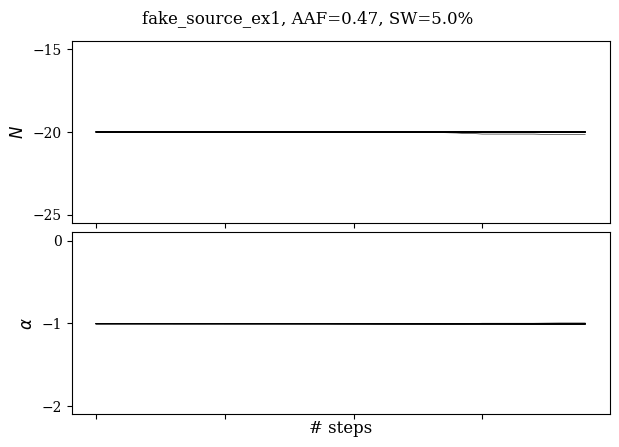

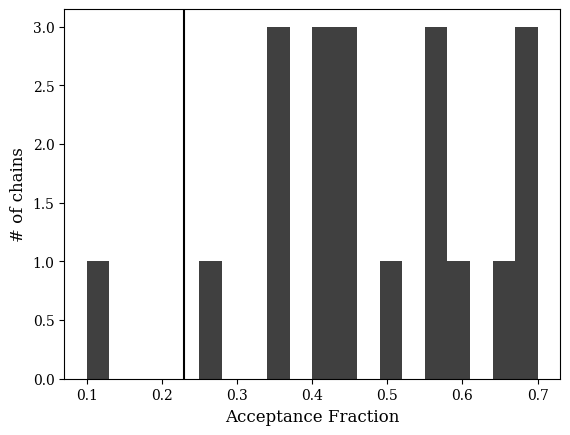

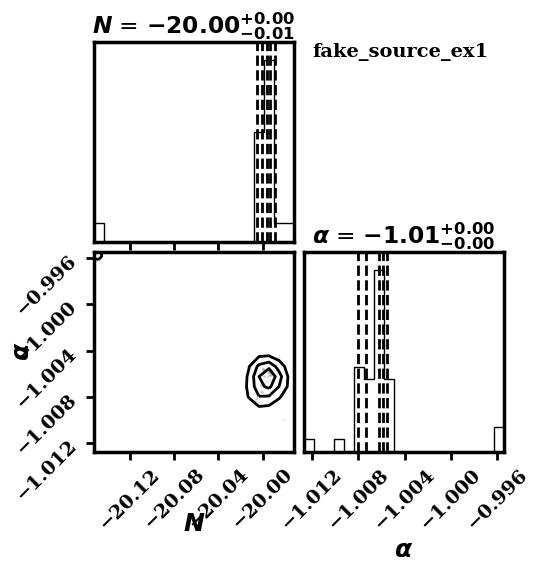

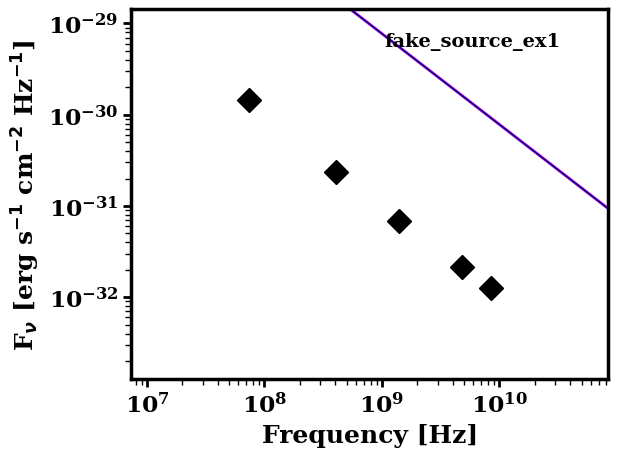

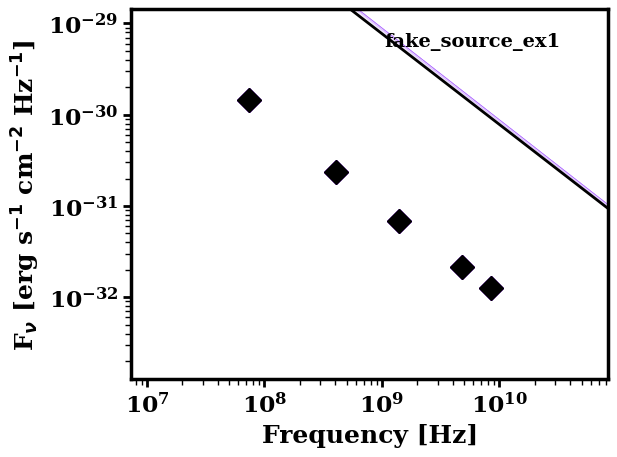

In [16]:
# graphical output
layout = 'publication'
AF_cut = 0.23   # set a value between 0 and 1, negative means a cut at mean/2
histo=True

gp.MC_Chains_plot(sampler, model_struct, fit_struct, layout=None, histo=histo, AF_cut=AF_cut)
gp.corner_plot(sampler, model_struct, fit_struct, AF_cut=AF_cut, layout=layout)

gp.SED_fnu_emcee_bestfit(data_struct, filter_struct, model_struct, fit_struct, layout=layout)
gp.SED_fnu_emcee_spaghetti(sampler, data_struct, filter_struct, model_struct, fit_struct, layout=layout, AF_cut=AF_cut)

with open(fit_struct['save_struct'], 'wb') as output:
    # format the model_struct as human readable and save
    model_sav = ut.format_sav_output(model_struct)
    yaml.dump([fit_struct,model_sav], output,allow_unicode=True, encoding=('utf-8'))
    # save the best fit SED simultaneously
    ut.save_bestfit_SED(data_struct, fit_struct, model_struct)


In [17]:
data_struct

[<Table length=5>
   filter       RA       Dec     ... arrangement component component_number
   str10       str9     str10    ...    int64       str4         str2      
 ---------- --------- ---------- ... ----------- --------- ----------------
 74MHz(VLA) 12h00m00s -40d00m00s ...           1      note                0
     408MHz 12h00m00s -40d00m00s ...           1      note                0
     1.4GHz 12h00m00s -40d00m00s ...           1      note                0
    4.85GHz 12h00m00s -40d00m00s ...           1      note                0
     8.4GHz 12h00m00s -40d00m00s ...           1      note               0,]

In [18]:
detection_mask = []
for i in range(len(data_struct)):
    detection_mask.append(data_struct[i]['det_type'] == 'd')


In [19]:
detection_mask[0][3]=False
detection_mask

[array([ True,  True,  True, False,  True])]

In [20]:
%timeit calc_chi2(data_struct[0]['flux'],data_struct[0]['flux_error'],[1e-26,]*5)

77.1 µs ± 6.68 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
%timeit calc_chi22(data_struct[0]['flux'],data_struct[0]['flux_error'],[1e-26,]*5)

NameError: name 'calc_chi22' is not defined

In [22]:
%timeit calc_chi222(data_struct[0]['flux'],data_struct[0]['flux_error'],[1e-26,]*5)

NameError: name 'calc_chi222' is not defined

In [ ]:
%timeit calc_chi2222(data_struct[0]['flux'],data_struct[0]['flux_error'],[1e-26,]*5)

In [ ]:
%timeit np.sum(np.array([1e4,1e-4,1e6,1e-5,1.]))

In [ ]:
%timeit sum([1e4,1e-4,1e6,1e-5,1.])

In [ ]:
toto=np.array([[1.,3.],[4.,2.]])
print(toto)

In [ ]:
toto[toto>=2]=3.

In [ ]:
toto